## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

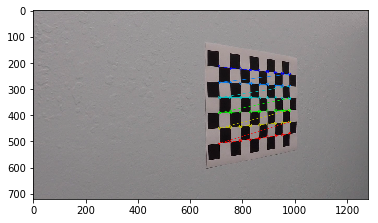

In [10]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# # Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# # Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#         # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## And so on and so forth...

In [14]:
# function that undistorts the image given object points (real points) and image points (points seen in the image)
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

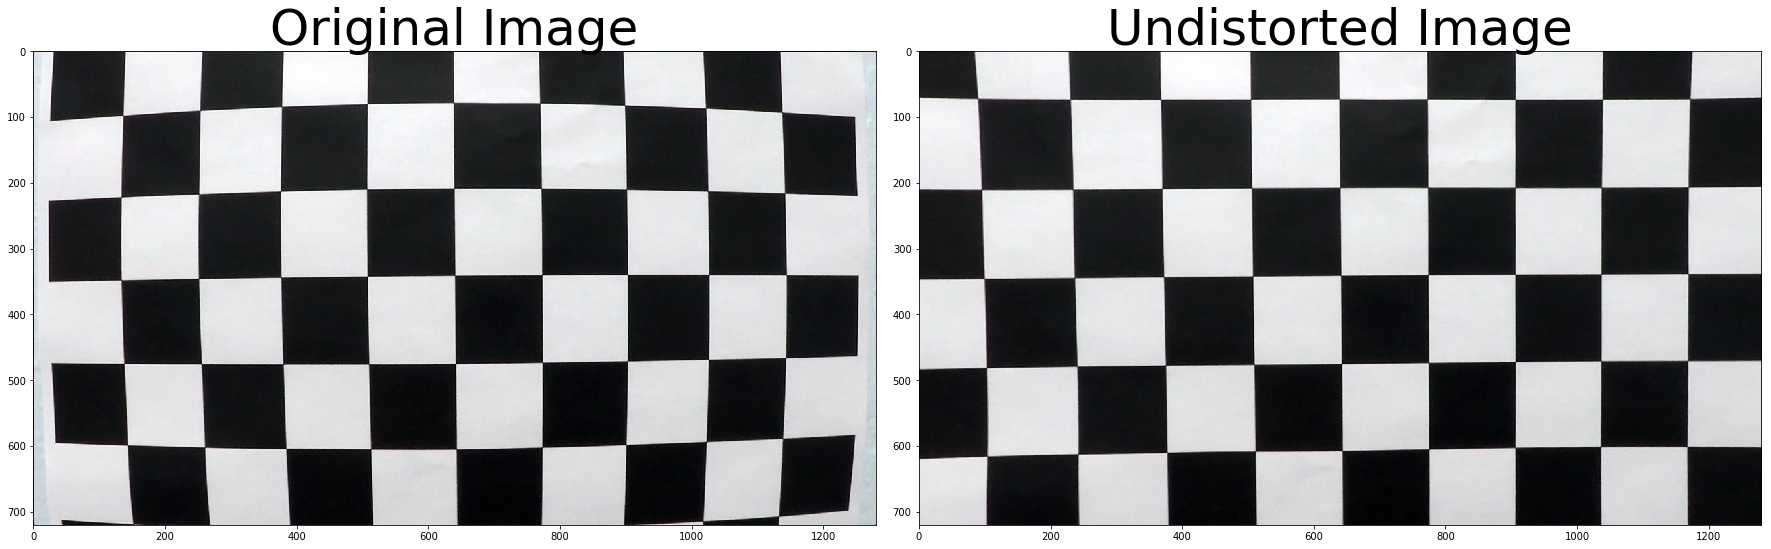

In [6]:
img = cv2.imread('../camera_cal/calibration1.jpg') # test image

undistorted = cal_undistort(img, objpoints, imgpoints) # apply undistort function created above

# below code takes care of showing the original image and the undistorted version of the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [57]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if len(img.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
#     gray = img
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print("Wrong orientation")
    abs_sobel = np.absolute(sobel)
    abs_scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(abs_scaled)
    grad_binary[(abs_scaled >= thresh[0]) & (abs_scaled <= thresh[1])] = 1
    return grad_binary

In [58]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
        
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag_scaled = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(mag_scaled)
    mag_binary[(mag_scaled >= mag_thresh[0]) & (mag_scaled <= mag_thresh[1])] = 1
    return mag_binary

In [59]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return dir_binary

In [60]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = img_hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    # binary_output = np.copy(img) # placeholder line
    return binary_output

In [61]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
#     Sobel x
    # Threshold x gradient
    sxbinary = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, thresh=sx_thresh)
#     sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
#     abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
#     scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
#     # Threshold x gradient
#     sxbinary = np.zeros_like(scaled_sobel)
#     sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
#     # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

(720, 1280, 3)


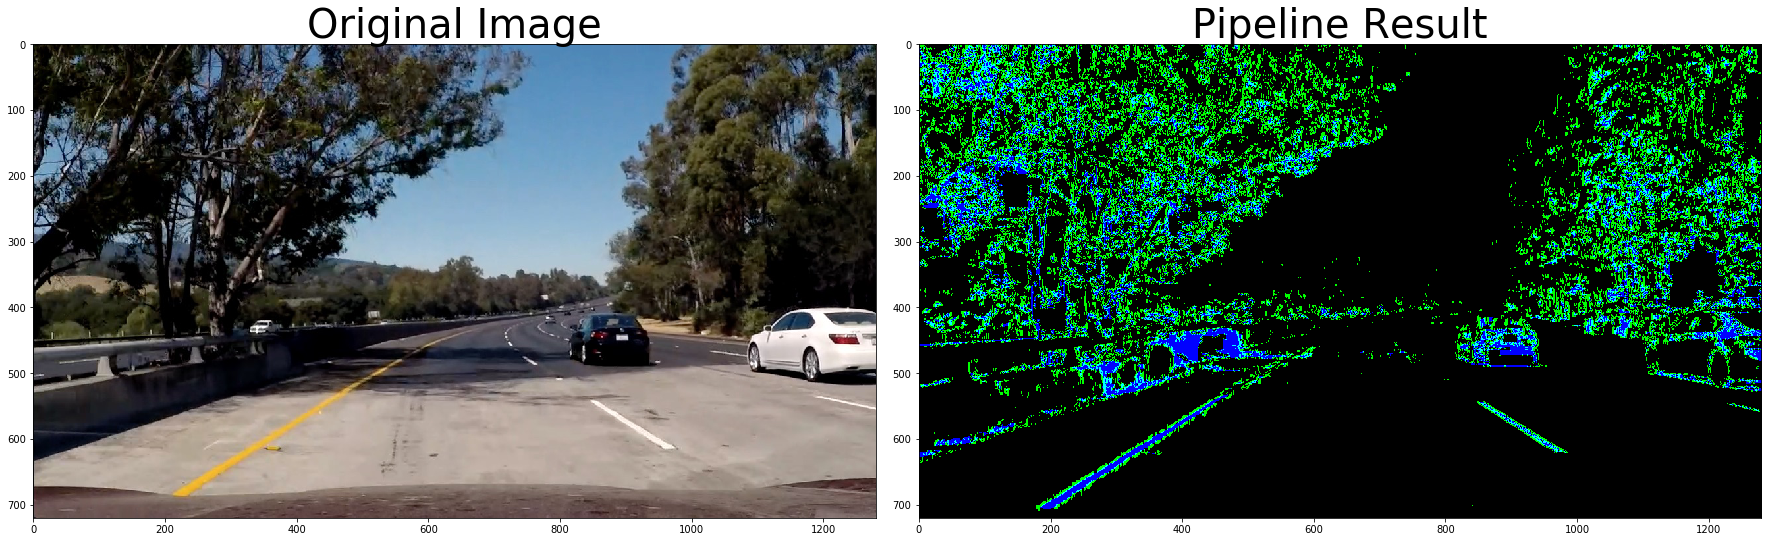

In [64]:
image = plt.imread('../test_images/test5.jpg') # test image
undistorted = cal_undistort(image, objpoints, imgpoints)
print(image.shape)
result = pipeline(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [79]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)  # keep same size as input image

    return warped


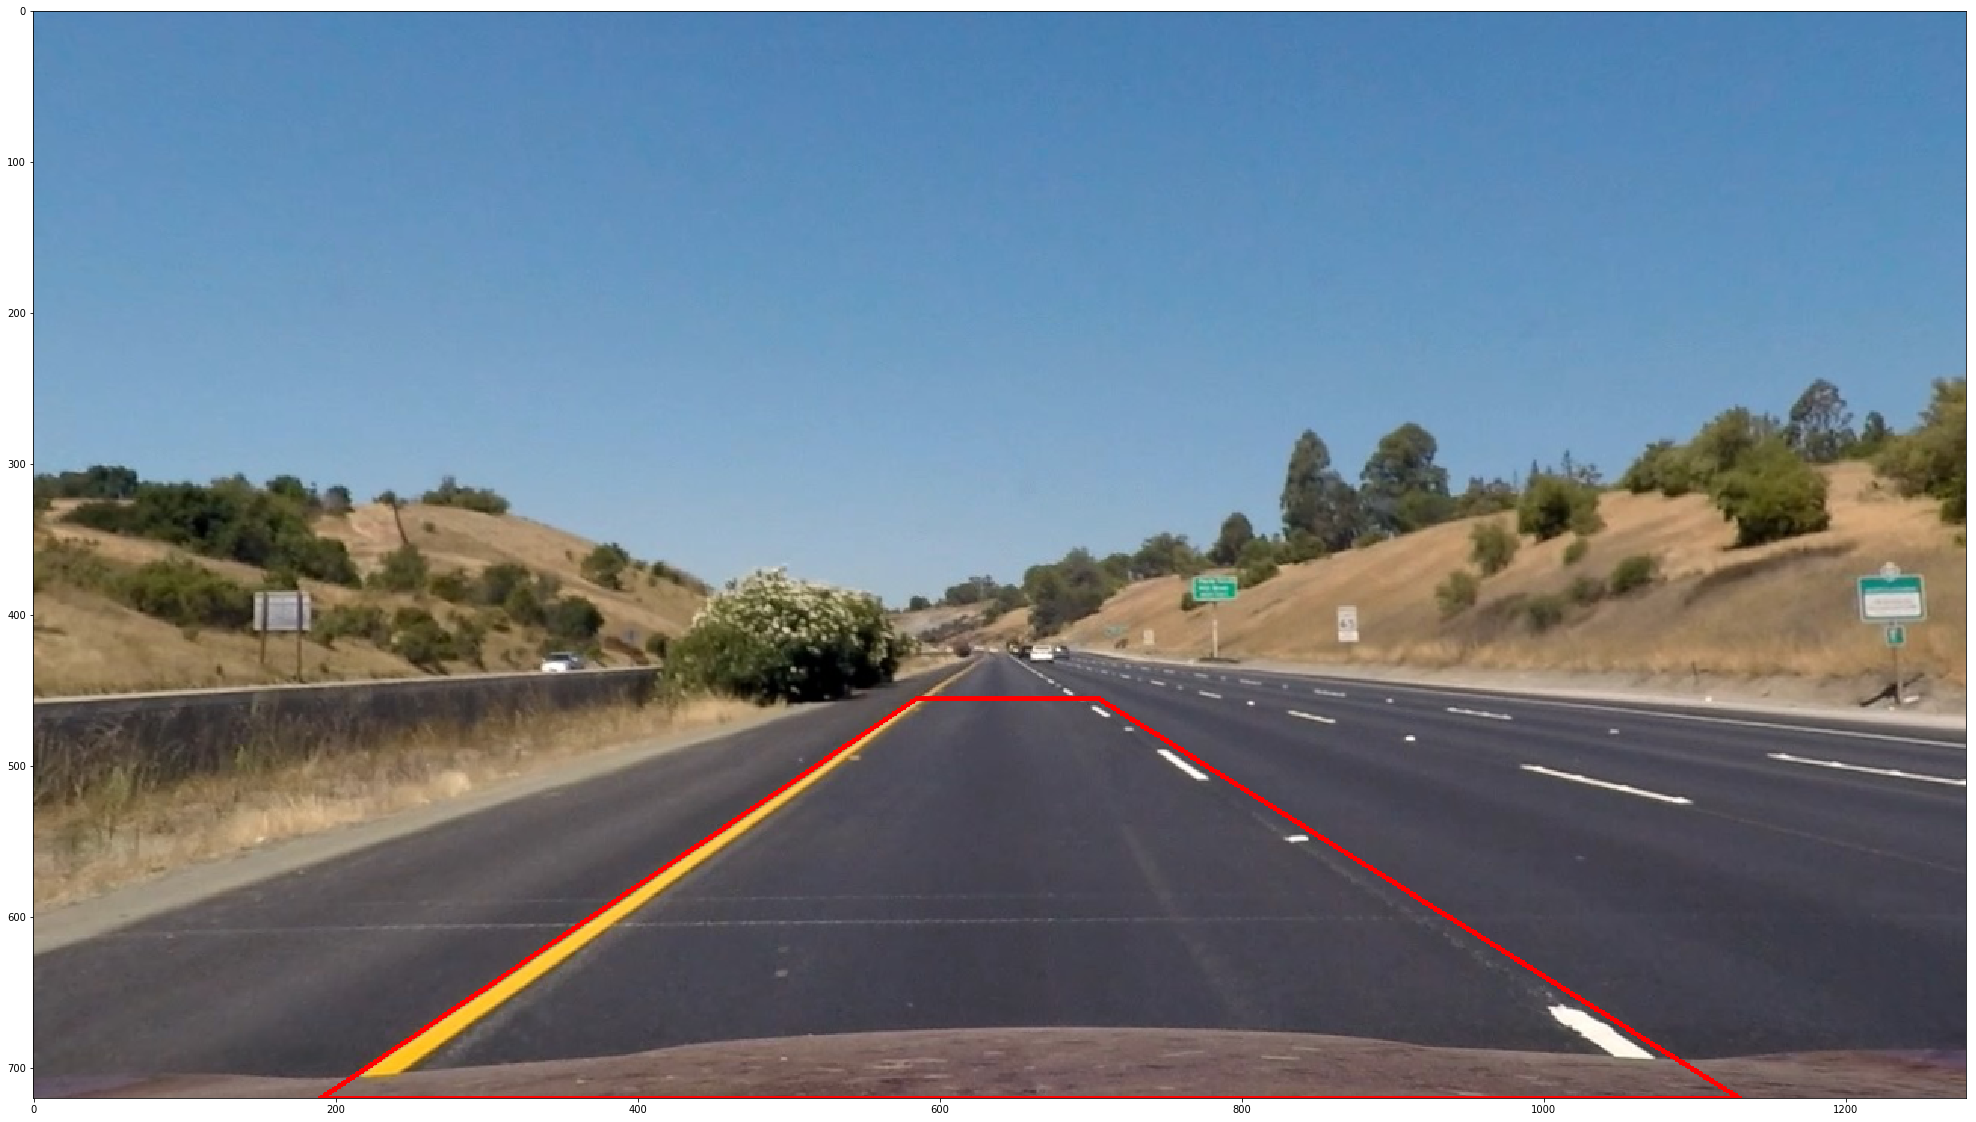

In [80]:
# original = image
image = plt.imread('../test_images/straight_lines1.jpg') # test image
undist = cal_undistort(image, objpoints, imgpoints)
copy = undist.copy()

bottomY = image.shape[0]
topY = 455


leftBott = (190, bottomY)
leftTop = (585, topY)
rightTop = (705, topY)

rightBott = (1130, bottomY)
# right2_x, right2_y = right2

color = [255, 0, 0]
w = 2
cv2.line(copy, leftBott, leftTop, color, w)
cv2.line(copy, leftTop, rightTop, color, w)
cv2.line(copy, rightTop, rightBott, color, w)
cv2.line(copy, rightBott, leftBott, color, w)
fig, ax = plt.subplots(figsize=(40, 20))
plt.imshow(copy)



src = np.float32([
    leftTop,
    rightTop,
    rightBott,
    leftBott])
img_size = (img.shape[1], img.shape[0])
offset = 200
dst = np.float32([
[offset, 0],
[img_size[0]-offset, 0],
[img_size[0]-offset, img_size[1]],
[offset, img_size[1]]])

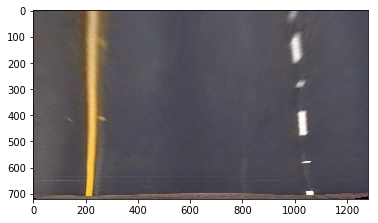

In [81]:
result = warper(image, src, dst)
plt.imshow(result)